<a href="https://colab.research.google.com/github/dlfrnaos19/FundamentalOfMachineLearning/blob/main/fundamental14_cat_puppy_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


## Dataset  
[Tensorflow Dataset](https://www.tensorflow.org/datasets/catalog/overview)

In [2]:
import tensorflow_datasets as tfds
tfds.__version__

'4.0.1'

Train set 80%, Valid set 10%, Test set 10%

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteFJ14Q6/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Height, Width, RGB Channel shape

In [4]:
print(raw_train, raw_validation, raw_test, sep='\n')

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


Check image status

In [5]:
import matplotlib.pyplot as plt

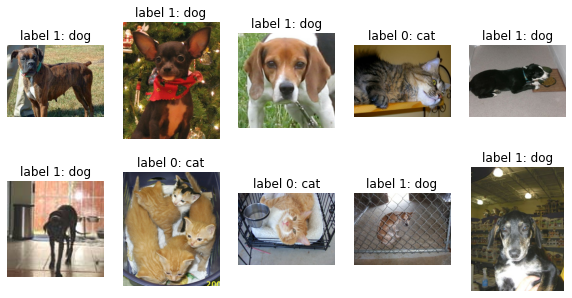

In [6]:
plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str
# take() create new dataset instance as much as parameter
for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## Image resize  
type casting  
해당 인스턴스를 슈퍼클래스나 하위 클래스로 취급하는 방법

In [7]:
img_size = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32) # type cast in tensorflow
    image = (image/127.5) - 1 # modify pixel scale -1 ~ 1
    image = tf.image.resize(image, (img_size, img_size))
    return image, label

Split train, valid, test set 

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train, validation, test, sep='\n')

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


This happens if plt.imshow() input value of image has negative

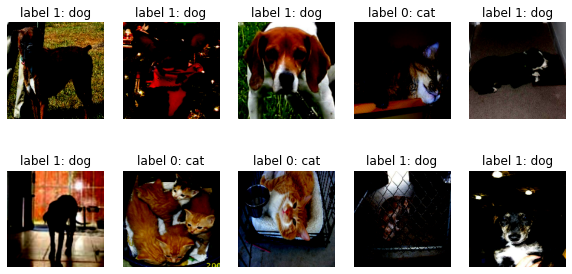

In [9]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    # image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

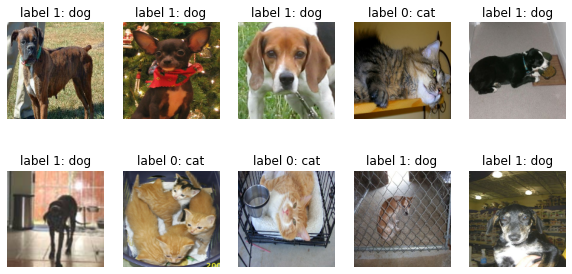

In [10]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

# Create Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,Flatten

In [12]:
Model = Sequential([
                    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160,160,3)),
                    MaxPooling2D(),
                    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(units=512, activation='relu'),
                    Dense(units=2, activation='softmax')
])
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0

[Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)

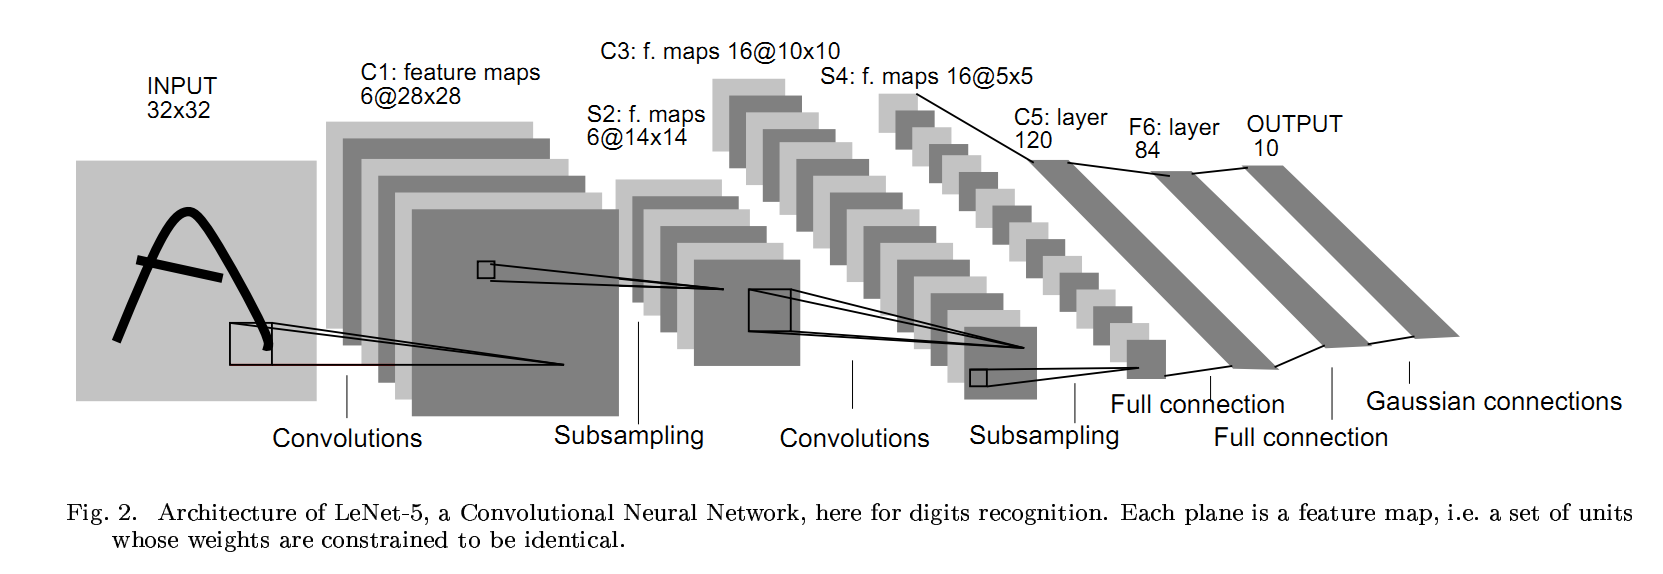

Understand of Flatten

In [13]:
import numpy as np
image = np.array([[1,2],[3,4]])
print(image.shape)
image

(2, 2)


array([[1, 2],
       [3, 4]])

In [14]:
image.flatten()

array([1, 2, 3, 4])

Modify Model
* optimizer: set how to train model
* loss: set the direction of learning
* metrics: Model evaluation 


In [70]:
learning_rate = 0.0001
Model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Batch: set number of data in 1 step  
SHUFFLE_BUFFER_SIZE: set data shuffle size

In [15]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [16]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

check if batch work

In [17]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

just test before train

In [74]:
validation_steps = 20
loss0, accuracy0 = Model.evaluate(validation_batches, steps=validation_steps)
print("initial loss: {:.2f}".format(loss0),"initial accuracy{:.2f}".format(accuracy0),sep="\n")


20/20 [==============================] - 7s 309ms/step - loss: 0.6899 - accuracy: 0.5359
initial loss: 0.69
initial accuracy0.54


# Model Train

In [75]:
epoch = 10
history = Model.fit(train_batches,
                    epochs=epoch,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 568s 972ms/step - loss: 0.5935 - accuracy: 0.6758 - val_loss: 0.5302 - val_accuracy: 0.7446
Epoch 2/10
168/582 [=======>......................] - ETA: 6:28 - loss: 0.5094 - accuracy: 0.7502

KeyboardInterrupt: ignored

# Report

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = Model.predict(image_batch)
    pass

predictions

In [ ]:
predictions = np.argmax(predictions, axis=1)
predictions

In [ ]:
plt.figure(figsize=(20,12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real:{label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color':'red'})
    else:
        plt.title(title,fontdict={'color':'blue'})
        plt.axis('off')

# Load Pretrained Model

ILSVRC: ImageNet Large Scale Visual Recognition Challenge  
Main Algorithms: *ResNet*, *VGG16*, *VGG19*, *Inception_V3*, *Xception* etc..  
[reference](https://www.sallys.space/blog/2018/01/26/cnn-imagenet/)  


## Transfer Learning
전이학습은 높은 정확도를 비교적 짧은 시간 내에 달성할 수 있기 때문에 컴퓨터 비전 분야에서 유명한 방법론 중 하나입니다 (Rawat & Wang 2017). 전이학습을 이용하면, 이미 학습한 문제와 다른 문제를 풀 때에도, 밑바닥에서부터 모델을 쌓아올리는 대신에 이미 학습되어있는 패턴들을 활용해서 적용시킬 수 있습니다. 이를 샤르트르 식으로 표현하면 거인의 어깨에 서서(standing on the soulder of giants) 학습하는 것이라고 할 수 있겠습니다!  
[reference](https://jeinalog.tistory.com/13https://)

## Fine Tuning
* train all(need big data, big GPU)
* train some convbase and classifier
* train classifier only

Fine tuning sequence
1. choose pretrained model
2. check similarity of model`s dataset and ours
3. finetuning with one of the 3 ways
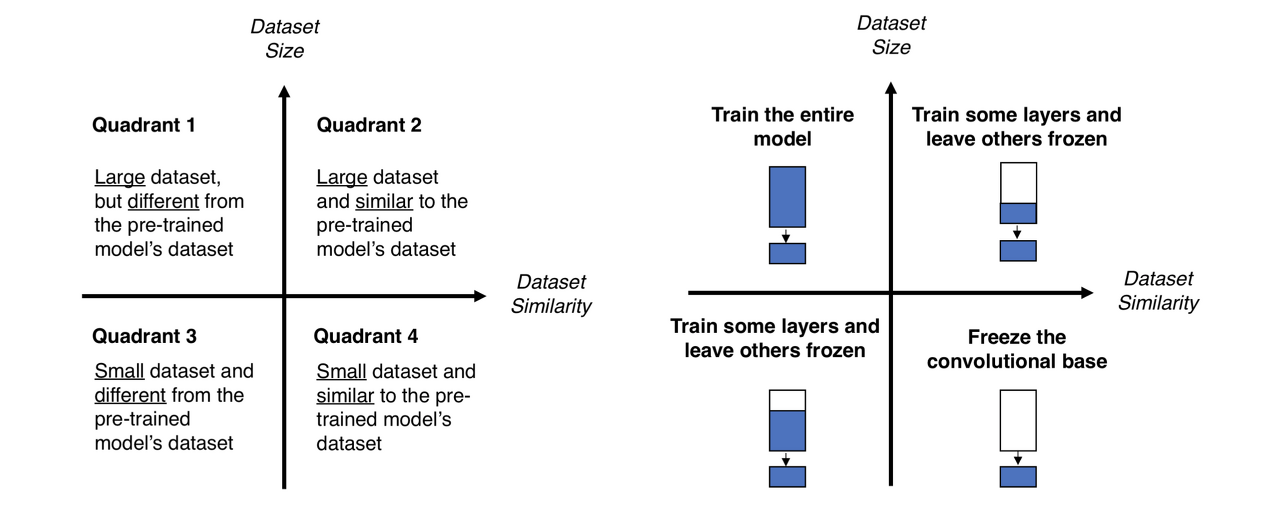

In [18]:
img_shape = (img_size, img_size, 3)
# load pretrained model
base_model = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [19]:
# how batch size change
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [20]:
# model structure
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

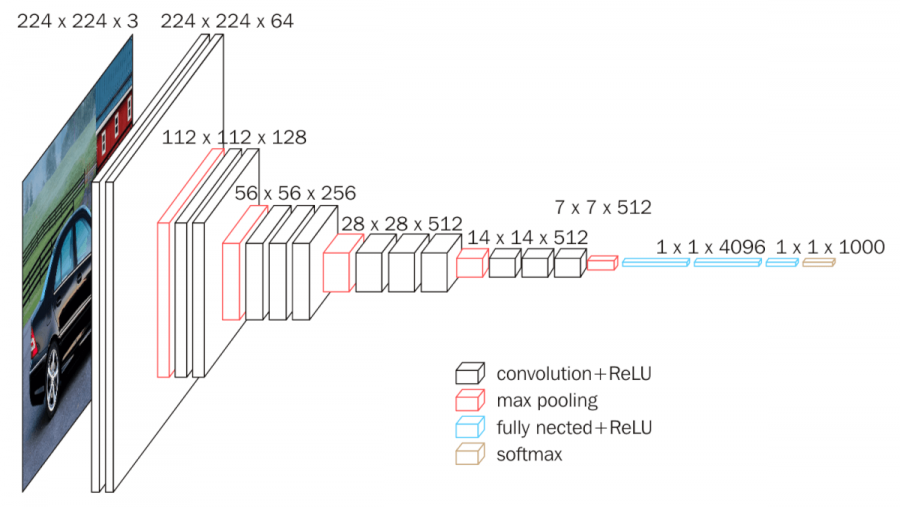

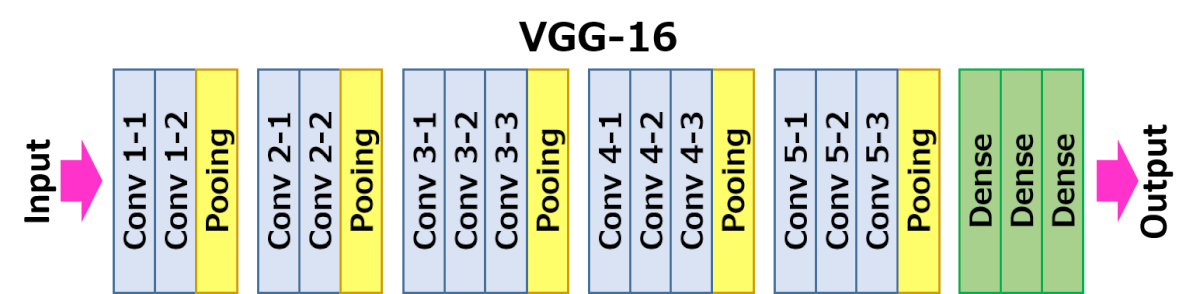

[reference](https://neurohive.io/en/popular-networks/vgg16/https://)

## Flatten? Global average pooling 2D

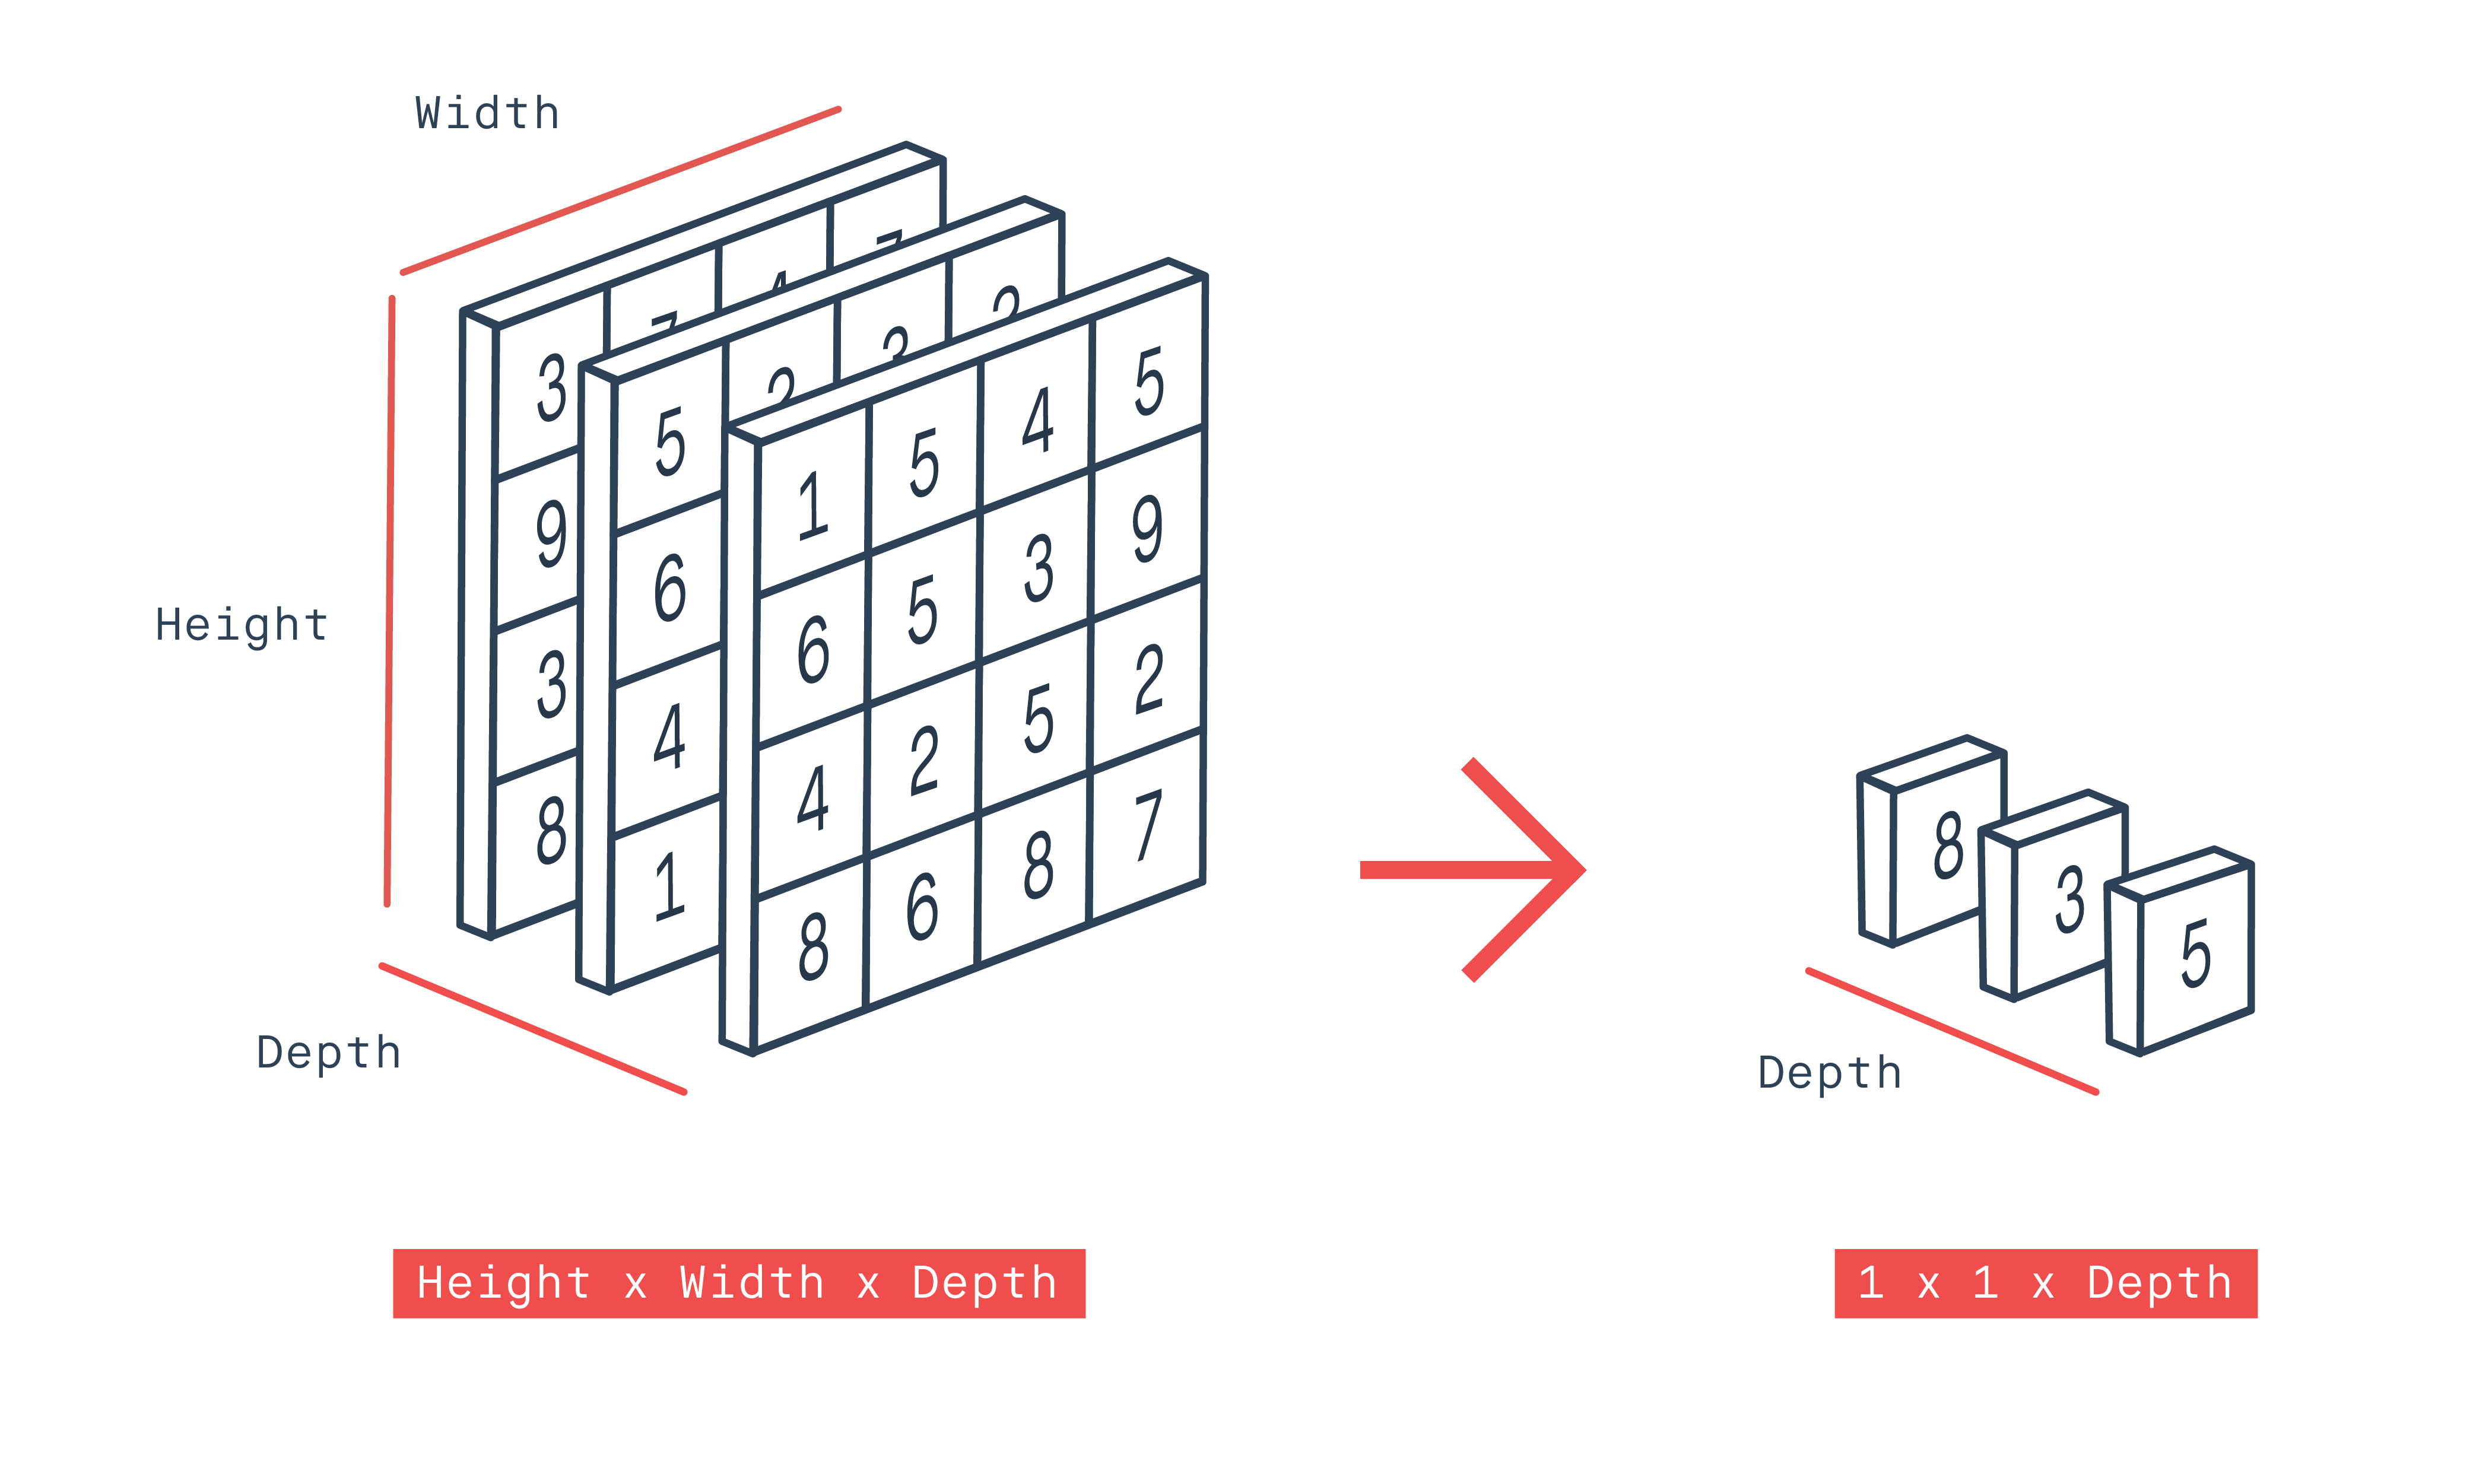

One dimension values -> One averaged value

## When to use  
Use global average pooling blocks as an alternative to the Flattening block after the last pooling block of your convolutional neural network. Using 2D Global average pooling block can replace the fully connected blocks of your CNN.

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [22]:
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 512])

[activation function reference](https://ganghee-lee.tistory.com/30)  
[Sigmoid, Hyperbolic, Tangent, Softmax, Relu](https://ynebula.tistory.com/42)

In [23]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

prediction_batch = prediction_layer(dense_layer(feature_batch_average))
print(prediction_batch.shape)

(32, 2)


In [24]:
# use model default value
base_model.trainable = False

In [25]:
# set model
model = tf.keras.Sequential([
                             base_model,
                             global_average_layer,
                             dense_layer,
                             prediction_layer
])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________


## Model Compile

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [90]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 166s 8s/step - loss: 0.7764 - accuracy: 0.4719
initial loss: 0.78
initial accuracy: 0.47


In [28]:
EPOCHS = 5 

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 125s 201ms/step - loss: 0.2564 - accuracy: 0.9067 - val_loss: 0.1722 - val_accuracy: 0.9316
Epoch 2/5
582/582 [==============================] - 112s 189ms/step - loss: 0.1597 - accuracy: 0.9355 - val_loss: 0.1541 - val_accuracy: 0.9334
Epoch 3/5
582/582 [==============================] - 112s 190ms/step - loss: 0.1453 - accuracy: 0.9417 - val_loss: 0.1460 - val_accuracy: 0.9372
Epoch 4/5
582/582 [==============================] - 113s 190ms/step - loss: 0.1388 - accuracy: 0.9417 - val_loss: 0.1425 - val_accuracy: 0.9398
Epoch 5/5
582/582 [==============================] - 111s 188ms/step - loss: 0.1344 - accuracy: 0.9449 - val_loss: 0.1493 - val_accuracy: 0.9385


## Report

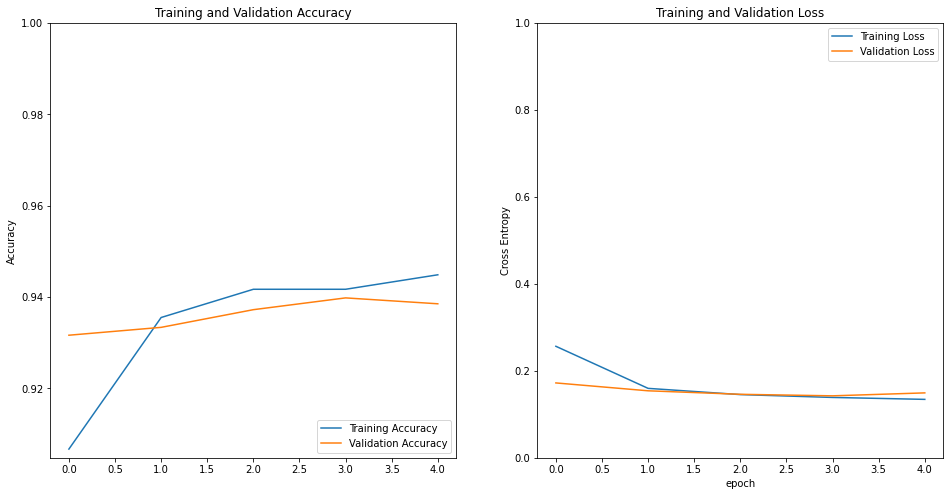

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9997723e-01, 2.2768143e-05],
       [6.9366239e-02, 9.3063378e-01],
       [2.2254124e-01, 7.7745873e-01],
       [9.9998927e-01, 1.0737032e-05],
       [9.9607807e-01, 3.9219633e-03],
       [9.8038447e-01, 1.9615497e-02],
       [7.9245729e-05, 9.9992073e-01],
       [5.4850566e-01, 4.5149434e-01],
       [9.1870874e-01, 8.1291303e-02],
       [9.3641168e-01, 6.3588373e-02],
       [2.8000528e-05, 9.9997199e-01],
       [9.9992692e-01, 7.3065639e-05],
       [9.7581542e-01, 2.4184577e-02],
       [2.0541765e-06, 9.9999797e-01],
       [9.9665147e-01, 3.3485915e-03],
       [9.7824144e-01, 2.1758527e-02],
       [9.9437088e-01, 5.6291549e-03],
       [1.2913610e-02, 9.8708642e-01],
       [4.6592021e-01, 5.3407979e-01],
       [9.9262422e-01, 7.3757614e-03],
       [8.6677164e-01, 1.3322838e-01],
       [9.7171175e-01, 2.8288214e-02],
       [9.9107856e-01, 8.9214677e-03],
       [9.5348537e-01, 4.6514608e-02],
       [9.9681515e-01, 3.1849218e-03],
       [9.6554393e-01, 3.

In [31]:
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

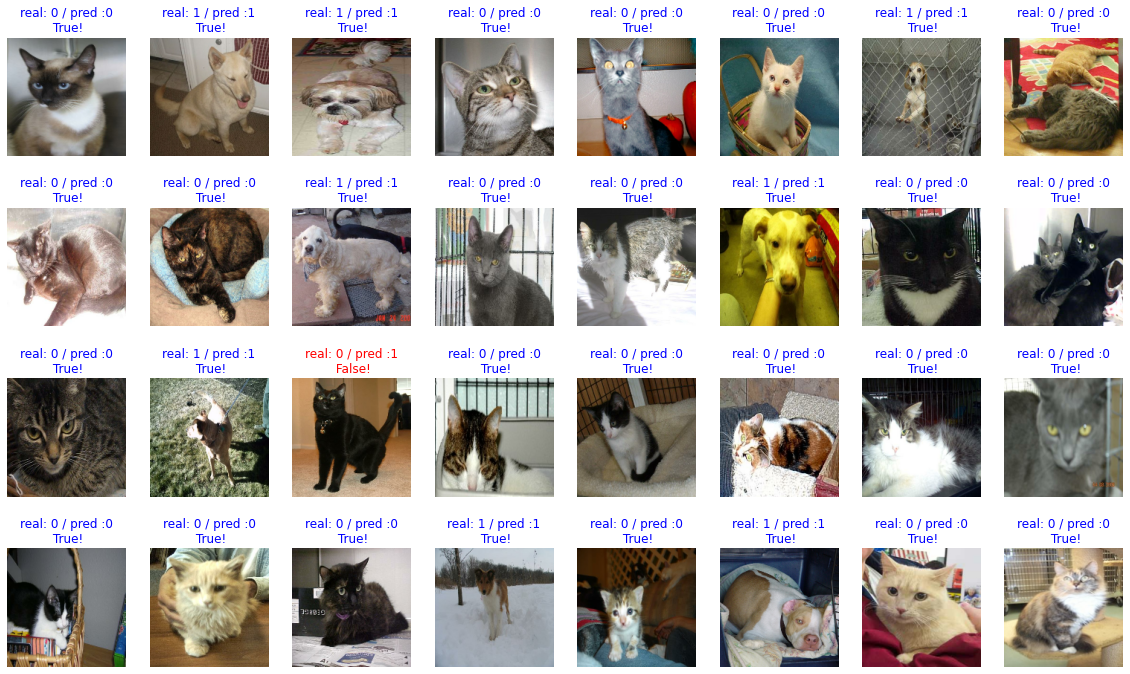

In [32]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [33]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

96.875


In [ ]:
import os

checkpoint_dir = '.'
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights('/content/checkpoint_dir')     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

In [36]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

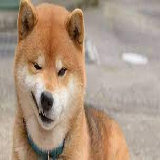

In [37]:
img_size = 160
dog_image = load_img('/content/dog.jpg', target_size=(img_size,img_size))
dog_image

In [39]:
dog_image = img_to_array(dog_image).reshape(1, img_size, img_size, 3)
dog_image.shape

(1, 160, 160, 3)

In [40]:
prediction = model.predict(dog_image)
prediction

array([[0., 1.]], dtype=float32)

In [41]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

This image seems 0% dog, and 100% cat.


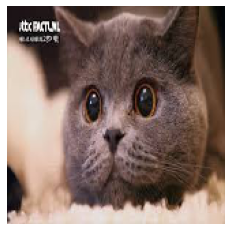

In [44]:
img_dir_path = '/content/'
filename = 'cat.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 100% dog, and 0% cat.


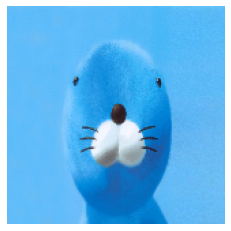

In [45]:
filename = 'bonobono.jpg'

show_and_predict_image(img_dir_path, filename)

This image seems 100% dog, and 0% cat.


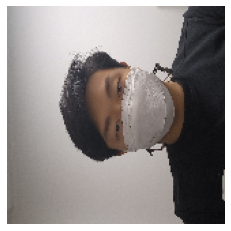

In [46]:
filename = 'me.jpg'

show_and_predict_image(img_dir_path, filename)